In [1]:

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


# from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../../..') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。
from util import *

In [2]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# implementation of PINNsformer
# paper: PINNsFormer: A Transformer-Based Framework For Physics-Informed Neural Networks
# link: https://arxiv.org/abs/2307.11833

import torch
import torch.nn as nn
import pdb

from util import get_clones


#自定义激活函数Wavelet：w1 * sin(x) + w2 * cos(x)
class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        #自定义两个可学习参数w1和w2，初始化为1，训练过程中会更新这两个参数
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

#MLP组件，第一层形状为(d_model, d_ff)，第二层形状为(d_ff, d_ff)，第三层形状为(d_ff, d_model)，前两个使用自定义激活函数WaveAct
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)

#编码器层
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True) #多头注意力，设置嵌入维度为d_model，头数为heads，batch_first=True表示输入和输出tensor以(批量大小,序列长度,嵌入维度) 形式提供
        self.ff = FeedForward(d_model) #MLP组件，输入和输出的形状均为d_model，隐藏层的形状为d_ff默认
        self.act1 = WaveAct() #激活函数
        self.act2 = WaveAct() #激活函数
        
    def forward(self, x): #形状为(点的数量，序列长度，d_model)
        x2 = self.act1(x) #对输入x应用激活函数
        # pdb.set_trace()
        x = x + self.attn(x2,x2,x2)[0] #多头注意力机制，查询、键和值均为原始输入经过激活函数后的x2，然后使用残差连接原始输入得到自注意力的输出
        x2 = self.act2(x) #对自注意力的输出应用激活函数
        x = x + self.ff(x2) #将通过激活函数后的自注意力输出通过MLP组件后残差连接原始自注意力输出，得到编码器的输出
        return x 


class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True) # 多头注意力，设置嵌入维度为d_model，头数为heads，batch_first=True表示输入和输出tensor以(批量大小,序列长度,嵌入维度) 形式提供
        self.ff = FeedForward(d_model) #MLP组件，输入和输出的形状均为d_model，隐藏层的形状为d_ff默认
        self.act1 = WaveAct() #激活函数
        self.act2 = WaveAct() #激活函数

    def forward(self, x, e_outputs): #输入形状为(点的数量，序列长度，d_model)，e_outputs为编码器的输出，形状也是为(点的数量，序列长度，d_model)
        x2 = self.act1(x) #将解码器输入x通过激活函数
        x = x + self.attn(x2, e_outputs, e_outputs)[0] #多头注意力机制，查询为解码器输入经过激活函数后的x2，键和值为编码器的输出e_outputs，然后使用残差连接原始输入得到自注意力的输出
        x2 = self.act2(x) #将自注意力的输出通过激活函数
        x = x + self.ff(x2) #将通过激活函数后的自注意力输出通过MLP组件后残差连接原始自注意力输出，得到解码器的输出
        return x

#编码器层，包含多个堆叠的编码器架构
class Encoder(nn.Module):
    def __init__(self, d_model, N, heads): #参数N代表编码器的头数，N代表包含几个编码器，d_model是数据的嵌入维度（用于每个编码器），heads是头的数量
        super(Encoder, self).__init__()
        self.N = N 
        self.layers = get_clones(EncoderLayer(d_model, heads), N) #N个编码器
        self.act = WaveAct()

    def forward(self, x): #输入一次通过N个编码器，x的形状为(点的数量，序列长度，d_model)
        for i in range(self.N):
            x = self.layers[i](x)
        return self.act(x) #编码器的输出要经过激活函数

#解码器层，包含多个堆叠的解码器架构
class Decoder(nn.Module):
    def __init__(self, d_model, N, heads): #参数N代表解码器的头数，N代表包含几个解码器，d_model是数据的嵌入维度（用于每个解码器），heads是头的数量
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N) #N个解码器
        self.act = WaveAct()
        
    def forward(self, x, e_outputs): #输入一次通过N个解码器层，x的形状为(点的数量，序列长度，d_model)，e_outputs为编码器的输出，形状也是为(点的数量，序列长度，d_model)
        for i in range(self.N): #输入和编码器输出依次通过N个解码器
            x = self.layers[i](x, e_outputs) 
        return self.act(x) #解码器的输出要经过激活函数



class DNN(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads): #接受参数为：d_out代表整个模型的输出的维度（就是最后的mlp层的输出维度），d_model代表每个点的特征嵌入维度，d_hidden代表最后的output layer模块中的隐藏层的维度，N代表编码器和解码器的层数，heads代表多头注意力机制的头数
        super(DNN, self).__init__()

        self.linear_emb = nn.Linear(1, d_model) #线性层，将输入的2维数据映射到d_model维度

        self.encoder = Encoder(d_model, N, heads) #编码器层
        self.decoder = Decoder(d_model, N, heads) #解码器层

        #输出的mlp模块，包含三个线性层，前两个使用自定义激活函数WaveAct，最终将feature从d_model维度映射到d_hidden维度，最后将d_hidden维度映射到d_out维度
        self.linear_hidden = nn.Sequential(*[
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, 1),
        ])
        self.linear_out = nn.Sequential(*[
            WaveAct(),
            nn.Linear(1, d_out),
            nn.Softmax(dim=-1)
        ])

    def forward(self, x): #输入的x形状一般为(点的数量, 序列长度, 1)
        src = x #形状为(点的数量，序列长度，1)
        src = self.linear_emb(src) #特征向量通过第一个线性层，映射到高维，此时src的形状为(点的数量，序列长度，d_model)，d_model代表每个点的特征

        e_outputs = self.encoder(src) #编码器处理输入特征向量，得到编码后的输出，形状为(点的数量，序列长度，d_model)
        d_output = self.decoder(src, e_outputs) #解码器处理输入特征向量和编码后的输出，得到解码后的输出，形状为(点的数量，序列长度，d_model)
        output_hidden = self.linear_hidden(d_output) #解码后的输出通过输出的mlp模块，得到最终的预测结果。形状为(点的数量，序列长度，1)，d_out代表输出的维度
        output = self.linear_out(output_hidden) #形状为(点的数量，序列长度，d_out)，d_out代表输出的维度
        # pdb.set_trace()
        # raise Exception('stop')
        return output #(点的数量，序列长度，d_out)
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        src = x #形状为(点的数量，序列长度，1)
        src = self.linear_emb(src) #特征向量通过第一个线性层，映射到高维，此时src的形状为(点的数量，序列长度，d_model)，d_model代表每个点的特征

        e_outputs = self.encoder(src) #编码器处理输入特征向量，得到编码后的输出，形状为(点的数量，序列长度，d_model)
        d_output = self.decoder(src, e_outputs) #解码器处理输入特征向量和编码后的输出，得到解码后的输出，形状为(点的数量，序列长度，d_model)
        output_hidden = self.linear_hidden(d_output) #解码后的输出通过输出的mlp模块，得到最终的预测结果。形状为(点的数量，序列长度，1)，d_out代表输出的维度
        # output = self.linear_out(output_hidden) #形状为(点的数量，序列长度，d_out)，d_out代表输出的维度
        # pdb.set_trace()
        # raise Exception('stop')
        return output_hidden #(点的数量，序列长度，1)

    
   

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)

        X_u = make_time_sequence(X_u, num_step=5, step=1e-4) #将形状从(点的数量，1)变为(点的数量，序列长度，1) 
        X_f = make_time_sequence(X_f, num_step=5, step=1e-4) #将形状从(点的数量，1)变为(点的数量，序列长度，1) 
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, dtype=torch.float32, requires_grad=True).to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, dtype=torch.float32, requires_grad=True).to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)

        
        # deep neural networks
        self.dnn = DNN(d_out=3, d_hidden=512, d_model=32, N=1, heads=2).to(device) 
        # self.dnn.apply(self.init_weights) #初始化模型中线性层的权重和偏置

        self.optimizer_LBFGS = torch.optim.LBFGS(self.dnn.parameters(), line_search_fn='strong_wolfe') #使用LBFGS优化器，line_search_fn='strong_wolfe'表示使用强Wolfe线搜索方法
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-8) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值


    def init_weights(self, m):
        if isinstance(m, nn.Linear): #判断是否是线性层
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
    

    #主动学习更新配位点数据    
    def update_data(self, X_u, u, X_f):
        mu_x, sigma_x = X_f.mean(0), X_f.std(0)
        X_u = (X_u - mu_x) / sigma_x
        X_f = (X_f - mu_x) / sigma_x

        self.mu_x = torch.tensor(mu_x).float().to(device)
        self.sigma_x = torch.tensor(sigma_x).float().to(device)

        X_u = make_time_sequence(X_u, num_step=5, step=1e-4) #将形状从(点的数量，1)变为(点的数量，序列长度，1) 
        X_f = make_time_sequence(X_f, num_step=5, step=1e-4) #将形状从(点的数量，1)变为(点的数量，序列长度，1) 
        
        self.X_u = torch.tensor(X_u, dtype=torch.float32, requires_grad=True).to(device)
        self.u = torch.tensor(u).float().to(device)
        self.X_f = torch.tensor(X_f, dtype=torch.float32, requires_grad=True).to(device)


        
    #(点的数量，序列长度，1)     
    def net_u(self, x):  
        u = self.dnn(x)  
        return u #(点的数量，序列长度，3) 
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #(点的数量，序列长度，3) 
        u1 = u[:,:, 0:1] #(点的数量，序列长度，1) 
        u2 = u[:,:, 1:2] #(点的数量，序列长度，1) 
        u3 = u[:,:, 2:3] #(点的数量，序列长度，1) 

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        #归一化
        u_x_1 = u_x_1 / self.sigma_x #(点的数量，序列长度，1) 
        u_x_2 = u_x_2 / self.sigma_x
        u_x_3 = u_x_3 / self.sigma_x
        
        #计算残差
        xx = x * self.sigma_x + self.mu_x
        residual_1 = u_x_1-(-2.572e-4*xx*u1)
        residual_2 = u_x_2-(1.12e-4*xx*u1-2.012e-4*xx*u2)
        residual_3 = u_x_3-(1.452e-4*xx*u1+2.012e-4*xx*u2)    



        loss_1 = torch.mean(residual_1 ** 2)
        loss_2 = torch.mean(residual_2 ** 2)
        loss_3 = torch.mean(residual_3 ** 2)

        loss_f = loss_1 + loss_2 + loss_3
        return loss_f, residual_1+ residual_2 + residual_3 #loss_f是一个数字，后者形状为#(点的数量，序列长度，1) 
    

    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        u_pred = self.net_u(self.X_u) ##(点的数量，序列长度，3) 
        u_pred = u_pred[:,0:1].reshape(-1,3) #(点的数量，序列长度，3)变为(点的数量，3)

        loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
        loss_f,_ = self.net_f(self.X_f) #计算残差的损失函数
        

        loss = loss_u + loss_f
        
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        self.iter += 1 #每调用一次损失函数，迭代次数加1

        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中


        return loss

      
    
    def train(self, nIter, nIterLBFGS): 


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) ##(点的数量，序列长度，3) 
            u_pred = u_pred[:,0:1].reshape(-1,3) #(点的数量，序列长度，3)变为(点的数量，3)

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f,_ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中



            #使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次
        for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            self.optimizer_LBFGS.step(self.loss_func) #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化


    def predict(self, X): #形状(点的数量，2)
        X = (X - self.mu_x.detach().cpu().numpy()) / self.sigma_x.detach().cpu().numpy() #对输入数据进行标准化处理
        X = make_time_sequence(X, num_step=5, step=1e-4) #将形状从(点的数量，1)变为(点的数量，序列长度，1) 
        X = torch.tensor(X, requires_grad=True).float().to(device)


        self.dnn.eval() #将神经网络切换为评估模式
        with torch.no_grad():
            u = self.net_u(X) #形状从(点的数量，序列长度，1)变为(点的数量，序列长度，3)
            u = u[:,0:1].reshape(-1,3) #将u的形状从(点的数量，序列长度，3)变为(点的数量，3)
            u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上

        return u #u形状是(点的数量，3)
    
    def residual(self, X): #形状(点的数量，2)
        X = (X - self.mu_x.detach().cpu().numpy()) / self.sigma_x.detach().cpu().numpy() #对输入数据进行标准化处理
        X = make_time_sequence(X, num_step=5, step=1e-4) #将形状从(点的数量，1)变为(点的数量，序列长度，1) 
        X = torch.tensor(X, requires_grad=True).float().to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        
        _,f = self.net_f(X) #形状从两个(点的数量，序列长度，1)变为(点的数量，序列长度，1)
        f = torch.mean(f, dim=1).reshape(-1,1) #对f在序列长度维度上求平均，得到(点的数量，1)，即每个点的平均残差
        # f = f[:,0:1].reshape(-1,1) #将f的形状从(点的数量，序列长度，1)变为(点的数量，1)
        f = f.detach().cpu().numpy()
        return f #u形状是(点的数量，1)，f形状是(点的数量，1)
    

    def hidden_predict(self, X):#形状(点的数量，序列长度，1)
        x = torch.tensor(X, requires_grad=True).float().to(device) #(点的数量，序列长度，1) 

        self.dnn.eval()
        with torch.no_grad():
            hidden_output = self.dnn.hidden_output(x) #(点的数量，序列长度，1)
            hidden_output = hidden_output.detach().cpu().numpy()
        # hidden_output_x = hidden_output[:, 0]
        # hidden_output_t = hidden_output[:, 1]
        # hidden_output_x = hidden_output_x.detach().cpu().numpy()
        # hidden_output_t = hidden_output_t.detach().cpu().numpy()
        return hidden_output #(点的数量，序列长度，1)



In [5]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [6]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0        

#读取真实解(基于MCS方法得到的解)
MCS_solution_df = pd.read_csv('MCS_non_homo_300.csv')
MCS_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

MCS_solution_df.drop(labels='time', inplace=True, axis = 1)


N_u = 1
N_f = 300



lb  = np.array([0.0])              # t的左边界
ub  = np.array([300.0])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0]])          # 初始真实状态
# X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点

error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值

i = 0 #初始化i为0

# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子
    lunshu = 10
    # --- 1. 参数设置 ---
    nIter = 2500
    nIterLBFGS = 0
    # ... 其他参数 ...

    # --- 2. 初始化 ---
    N_f_1 = N_f // lunshu
    X_f_train = lb + (ub - lb) * lhs(1, N_f_1)
    model = PhysicsInformedNN(X_u, u, X_f_train, lb, ub)

    # 【新】创建巨大、固定的候选点池
    N_f_candidate = N_f * 2
    X_f_candidate = lb + (ub - lb) * lhs(1, N_f_candidate)
    is_point_selected_mask = np.zeros(N_f_candidate, dtype=bool) #布尔掩码，形状是(N_f_candidate,)，初始值为False，表示所有点都未被选择

    

    # --- 3. 初始训练 ---
    start_time = time.time()
    model.train(nIter // lunshu, 0)

    # --- 4. 主动学习循环 ---
    # 计算总轮数,这里是19
    num_active_rounds = (nIter - nIter // lunshu) // (nIter // lunshu)
    # 每轮训练中记录的检查点数量，其实就是后面的T
    num_checkpoints_per_round = 10
    # 两次检查点之间的训练迭代次数
    epochs_between_checkpoints = (nIter // lunshu) // num_checkpoints_per_round

    # 用于存储每一轮最终预测的全局历史
    global_final_predictions = []

    for i in range(num_active_rounds):        
        # a. 训练并记录预测历史
        prediction_history = []
        # 记录当前模型在整个候选池上的预测输出
        
        for j in range(num_checkpoints_per_round):
            model.train(epochs_between_checkpoints, 0)
            
            # 记录当前模型在整个候选池上的预测输出
            predictions = model.predict(X_f_candidate) # 返回 (N, 3) 的Numpy数组
            # prediction_history.append(predictions.flatten()) # 存为一维数组，每个元素形状为 (N, ) 
            prediction_history.append(predictions) # 存为二维数组，每个元素形状为 (N, 3)
        local_prediction_history = prediction_history

        # b. 计算不稳定性分数 g(x) = Σ v_t * a_t(x)
        # 将历史记录转为矩阵 (T+1, N_candidates,3)
        local_history_matrix = np.array(local_prediction_history)
        T_local, num_candidates, _ = local_history_matrix.shape #T表示共存储了多少个模型的预测结果，num_candidates表示候选点的数量

        # 获取最终预测u_T(x)
        local_final_prediction = local_history_matrix[-1, :, :] # (N_candidates, 3) 的数组

        # 计算不一致性矩阵 a_t(x) = |u_t(x) - u_T(x)|
        # 利用 NumPy 的广播机制高效计算，具体为(T, N_candidates,3)-(N_candidates,3)（相当于用T个元素分别和最后一个元素相减）,最后得到的形状是(T, N_candidates)
        # disagreement_matrix_A = np.abs(prediction_history_matrix - final_prediction_vec)
        local_disagreement = np.linalg.norm(local_history_matrix - local_final_prediction, ord=2, axis=-1)

        # 计算时间权重向量 v_t = (t/T)^k
        t_local = np.arange(1, T_local + 1) #形状是(T,)的数组
        k_local = 1.0  # 权重指数，可以作为超参数调整
        v_local = (t_local / T_local) ** k_local #形状是(T,)

        # 计算最终不稳定性分数 g(x)
        # g = V^T * A (矩阵乘法概念)
        # 实际操作：将权重向量V变形以进行逐元素乘法，然后在时间轴上求和
        # v_local（也就是V）的形状是(T,)，local_disagreement（也就是A）的形状是(T, N_candidates)
        # V[:, np.newaxis] 将V变为 (T, 1)，可以与A进行广播乘法
        g_micro = np.sum(v_local[:, np.newaxis] * local_disagreement, axis=0) #求和前形状为 (T, N_candidates)，求和后形状为(N_candidates,)

        
        # c. 更新并计算【宏观不稳定性 g_macro】
        # ------------------------------------------------------------------
        # 将本轮的最终预测加入全局历史列表
        global_final_predictions.append(local_final_prediction)
        
        g_macro = np.zeros(num_candidates) # 如果历史太短，宏观不稳定性为0
        
        # 只有当全局历史足够长时（至少有两次最终预测），计算才有意义
        if len(global_final_predictions) > 1:
            global_history_matrix = np.array(global_final_predictions)
            T_global, _, _ = global_history_matrix.shape # T_global 是当前的主动学习轮数 i+1
            
            # 使用全局最新的预测作为基准
            global_final_prediction = global_history_matrix[-1, :, :]
            
            # 计算宏观不一致性
            global_disagreement = np.linalg.norm(global_history_matrix - global_final_prediction, ord=2, axis=-1)
            
            # 【宏观 t, k】
            t_global = np.arange(1, T_global + 1)
            k_macro = 2.0 # 宏观时间尺度上，可以给后期变化更大的惩罚，所以k可以更大
            v_global = (t_global / T_global) ** k_macro
            
            # 计算宏观不稳定性分数
            g_macro = np.sum(v_global[:, np.newaxis] * global_disagreement, axis=0)


        # d. 融合分数
        # ------------------------------------------------------------------
        # 在融合前，对两种分数进行归一化，使其尺度相当，避免其中一个主导
        # 这是一个很好的实践，可以防止数值问题
        if np.std(g_micro) > 1e-6:
            g_micro_norm = (g_micro - np.mean(g_micro)) / np.std(g_micro)
        else:
            g_micro_norm = np.zeros_like(g_micro)

        if np.std(g_macro) > 1e-6:
            g_macro_norm = (g_macro - np.mean(g_macro)) / np.std(g_macro)
        else:
            g_macro_norm = np.zeros_like(g_macro)
            
        # 设置融合权重
        w_micro = 0.5
        w_macro = 0.5
        
        instability_scores_g = w_micro * g_micro_norm + w_macro * g_macro_norm



        # batch_size = N_f_candidate // 10 # 设置批处理大小为候选点数量的十分之一，避免显存爆炸
        # all_residuals = [] # 创建一个空列表来存储每个批次的残差结果


        # # 循环处理每个批次
        # for i in range(0, N_f_candidate, batch_size):
        #     # 获取当前批次的数据
        #     X_batch = X_f_candidate[i : i + batch_size]
            
        #     # 对当前批次计算残差
        #     # model.residual 内部的计算量大大减小，不会爆显存了
        #     residual_batch = model.residual(X_batch) # 返回 (batch_size, 1) 的 NumPy 数组
            
        #     # 将当前批次的结果添加到列表中
        #     all_residuals.append(residual_batch)

        # # 将所有批次的结果拼接成一个大的 NumPy 数组
        # residual = np.vstack(all_residuals) # vstack 用于垂直堆叠

        # # --- 后续处理不变 ---
        # # 计算残差的绝对值
        # abs_residual = np.abs(residual)
        # # 将二维数组转换为一维数组
        # abs_residual = abs_residual.flatten()



        #进行归一化
        epsilon = 1e-5
        
        # norm_residual = np.linalg.norm(abs_residual)
        # if norm_residual > epsilon:
        #     abs_residual = abs_residual / norm_residual
        # else:
        #     abs_residual = np.zeros_like(abs_residual)
        # norm_distances = np.linalg.norm(distances)
        # if norm_distances > epsilon:
        #     distances = distances / norm_distances
        # else:
        #     distances = np.zeros_like(distances)

        norm_instability = np.linalg.norm(instability_scores_g)
        if norm_instability > epsilon:
            instability_scores_g = instability_scores_g / norm_instability
        else:
            instability_scores_g = np.zeros_like(instability_scores_g)

        xinxi = instability_scores_g #将残差和不稳定性分数相加，得到新的分数


        # e. 选择新的点
        # 屏蔽已选中的点，防止重复选择
        xinxi[is_point_selected_mask] = -1.0
        
        # 找出分数最高的 N_f_1 个点的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:]
        
        # 提取新点
        X_f_train_topk = X_f_candidate[topk_indices]
        
        # f. 更新训练集和掩码
        X_f_train = np.vstack((X_f_train, X_f_train_topk))
        is_point_selected_mask[topk_indices] = True


        model.update_data(X_u, u, X_f_train) #更新模型的初边界点数据和配位点数据



    model.train(nIter,nIterLBFGS) #使用LBFGS训练500次




    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    # #真实值
    # mu, sigma = model.mu_x, model.sigma_x

    # up = 80000
    n_star = 300+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred = model.predict(x_star)
    y_star = MCS_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star - y_pred))
    mse = np.mean((y_star - y_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)


Adam: 100%|██████████| 250/250 [00:03<00:00, 68.84it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 73.50it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 68.52it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 70.51it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 73.41it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 68.47it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 72.78it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 73.72it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 73.93it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 72.15it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 71.03it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 73.45it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00

Training time: 71.9498
当前为第9次循环，种子为0
Error y : 3.263732e-02
MAE: 1.168223e-02
MSE: 2.263077e-04


Adam: 100%|██████████| 250/250 [00:03<00:00, 64.21it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 62.17it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 67.31it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 64.98it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 62.82it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 64.71it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 64.11it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 67.40it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 66.57it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 64.52it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 65.15it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 67.25it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00

Training time: 78.6320
当前为第9次循环，种子为1
Error y : 2.278440e-01
MAE: 8.788606e-02
MSE: 1.161867e-02


Adam: 100%|██████████| 250/250 [00:03<00:00, 64.30it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 63.89it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 64.71it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 64.90it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 63.83it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 66.79it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 62.39it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 64.28it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 62.81it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 61.14it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 67.31it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 61.54it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00

Training time: 78.8920
当前为第9次循环，种子为12
Error y : 9.725517e-01
MAE: 3.581370e-01
MSE: 1.889682e-01


Adam: 100%|██████████| 250/250 [00:03<00:00, 65.89it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 65.58it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 67.03it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 63.02it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 64.66it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 67.24it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 66.64it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 65.40it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 65.29it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 65.90it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 64.65it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 62.04it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00

Training time: 78.7008
当前为第9次循环，种子为33
Error y : 9.106382e-01
MAE: 3.458563e-01
MSE: 1.795847e-01


Adam: 100%|██████████| 250/250 [00:04<00:00, 57.49it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 64.59it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 66.17it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 66.64it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 66.92it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 67.64it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 65.41it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 64.98it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 62.21it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 65.13it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 67.40it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 66.08it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00

Training time: 79.2926
当前为第9次循环，种子为123
Error y : 3.339219e-01
MAE: 9.198551e-02
MSE: 2.276971e-02


Adam: 100%|██████████| 250/250 [00:04<00:00, 57.55it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 62.44it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 67.43it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 66.08it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 67.99it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 66.84it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 63.97it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 67.27it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 64.04it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 64.98it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 63.07it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 65.81it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00

Training time: 79.0227
当前为第9次循环，种子为321
Error y : 6.138520e-01
MAE: 2.203968e-01
MSE: 9.276215e-02


Adam: 100%|██████████| 250/250 [00:04<00:00, 57.16it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 63.46it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 66.69it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 68.97it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 63.25it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 64.52it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 65.25it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 66.87it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 67.35it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 65.71it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 68.58it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 63.33it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00

Training time: 78.8402
当前为第9次循环，种子为1234
Error y : 8.544343e-01
MAE: 3.262385e-01
MSE: 1.633467e-01


Adam: 100%|██████████| 250/250 [00:04<00:00, 58.14it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 65.81it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 63.15it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 66.98it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 66.69it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 68.14it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 68.10it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 63.94it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 66.20it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 65.25it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 66.06it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 67.76it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00

Training time: 78.9943
当前为第9次循环，种子为4321
Error y : 1.040635e-01
MAE: 3.551323e-02
MSE: 2.234178e-03


Adam: 100%|██████████| 250/250 [00:04<00:00, 57.77it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 66.35it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 66.04it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 65.69it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 65.32it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 64.86it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 61.20it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 64.86it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 63.24it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 67.31it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 67.65it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 64.26it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00

Training time: 79.2500
当前为第9次循环，种子为12345
Error y : 1.324204e-01
MAE: 4.067611e-02
MSE: 3.567694e-03


Adam: 100%|██████████| 250/250 [00:04<00:00, 57.61it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 64.23it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 66.82it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 61.47it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 67.93it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 64.49it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 65.43it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 66.91it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 65.12it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 64.27it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 67.05it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00:00, 61.18it/s]
LBFGS: 0it [00:00, ?it/s]
Adam: 100%|██████████| 25/25 [00:00<00

Training time: 79.4435
当前为第9次循环，种子为54321
Error y : 1.166831e+00
MAE: 4.283233e-01
MSE: 2.891101e-01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(300, 1)


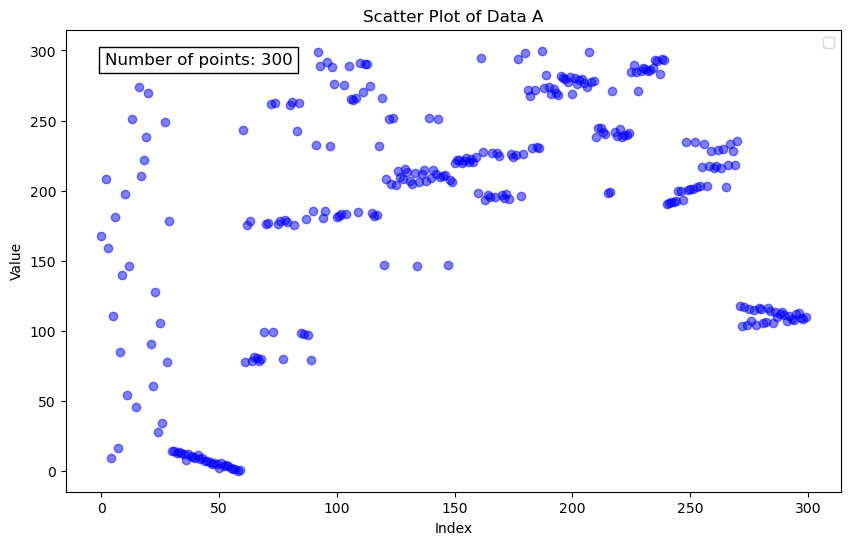

In [7]:
print(X_f_train.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f_train)), X_f_train, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(300, 1)


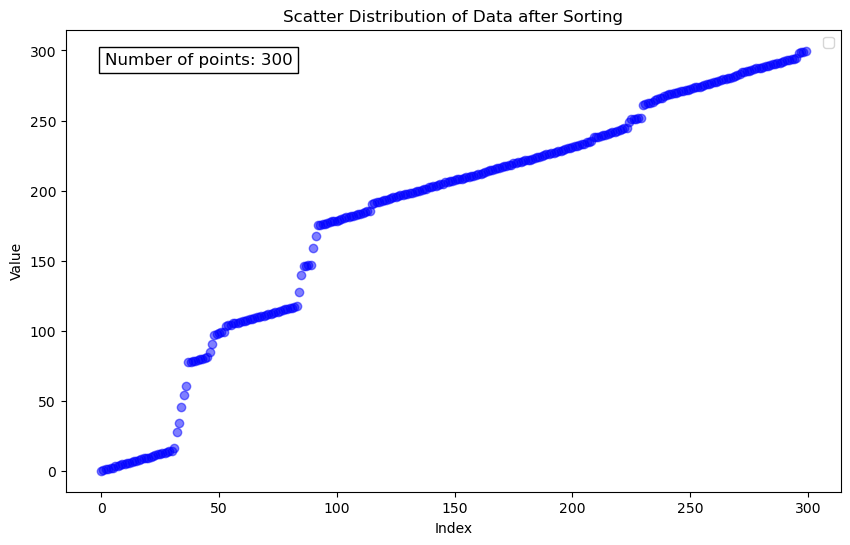

In [8]:
X = np.sort(X_f_train, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [9]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE




[0.0326373221295394, 0.2278440143550841, 0.9725517123616193, 0.9106381841386614, 0.33392192783869595, 0.6138520290452399, 0.8544342896900148, 0.1040635373355937, 0.13242035058344537, 1.1668313964390018]
Error u of fuhe active learning(LHS sampling): 5.349195e-01
[0.011682226401040118, 0.08788605961949343, 0.35813695997123196, 0.34585630265222206, 0.09198551490411094, 0.2203968420973624, 0.3262384800858465, 0.035513226077741024, 0.04067610942582019, 0.42832329681921794]
MAE of fuhe active learning(LHS sampling): 1.946695e-01
[0.0002263076661233802, 0.011618670938544677, 0.1889682068955405, 0.17958471527969663, 0.0227697105482632, 0.09276214917100041, 0.16334666272243037, 0.0022341775728771857, 0.0035676944619969877, 0.28911010995096403]
MSE of fuhe active learning(LHS sampling): 9.541884e-02


In [10]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

5000


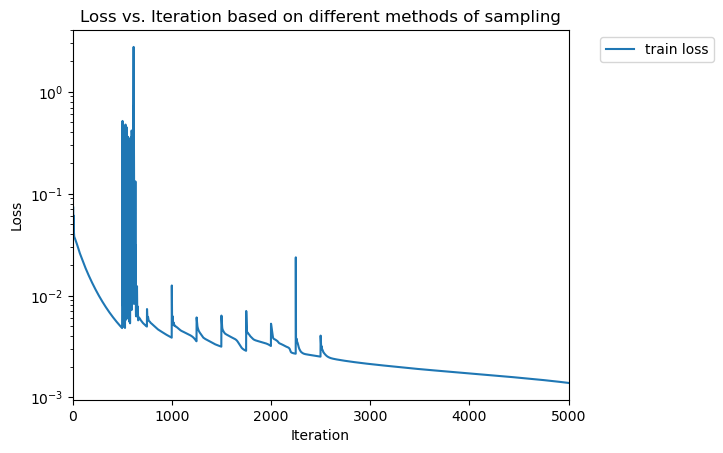

In [11]:
print(len(trainloss))

# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,len(trainloss)]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

Text(0, 0.5, 'Probability')

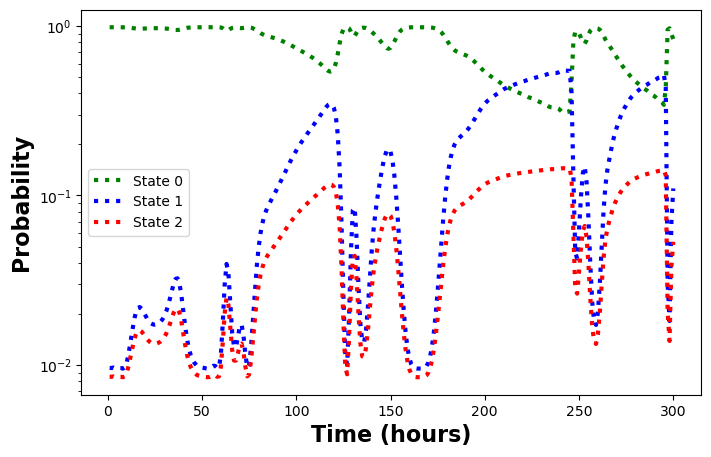

In [12]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'State 0', linewidth = 3, color = 'green', linestyle='dotted')
#绘制第一条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第一列，设置这条线的标签为State 0，线宽为5，颜色为绿色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'State 1', linewidth = 3, color = 'blue', linestyle='dotted')
#绘制第二条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第二列，设置这条线的标签为State 1，线宽为5，颜色为蓝色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'State 2', linewidth = 3, color = 'red', linestyle='dotted')
#绘制第三条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第三列，设置这条线的标签为State 2，线宽为5，颜色为红色，线型为点线

plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

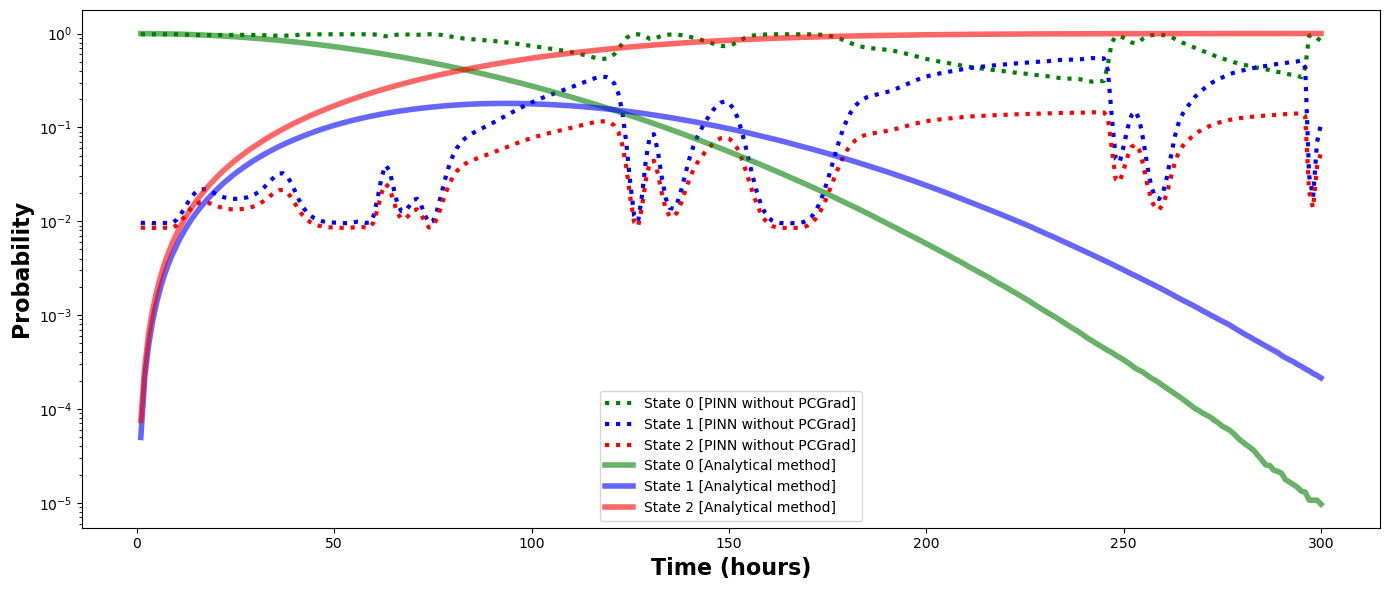

In [13]:
# 创建一个子图
f, ax = plt.subplots(1, 1, figsize=(14, 6))

# 绘制 PINN without PCGrad 方法的预测结果
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 0], label='State 0 [PINN without PCGrad]', linewidth=3, color='green', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 1], label='State 1 [PINN without PCGrad]', linewidth=3, color='blue', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 2], label='State 2 [PINN without PCGrad]', linewidth=3, color='red', linestyle='dotted', ax=ax)

# 绘制 Runge-Kutta 方法的结果
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_0'], label='State 0 [Analytical method]', color='green', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_1'], label='State 1 [Analytical method]', color='blue', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_2'], label='State 2 [Analytical method]', color='red', alpha=0.6, dashes=True, linewidth=4, ax=ax)


# 设置 y 轴为对数刻度
ax.set_yscale("log")
# ax.set_ylim([1e-9, 2])
ax.set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)

# 自动调整子图参数
plt.tight_layout()


# 显示图形
plt.show()

### 计算RMSE

In [14]:
y_pred_df = pd.DataFrame(y_pred, columns = ['state_0', 'state_1', 'state_2'])
print(y_pred_df.head())
print(y_pred_df.tail())

    state_0   state_1   state_2
0  0.981838  0.009622  0.008540
1  0.981866  0.009606  0.008528
2  0.981757  0.009671  0.008572
3  0.981946  0.009558  0.008496
4  0.981972  0.009542  0.008485
      state_0   state_1   state_2
295  0.432234  0.436173  0.131594
296  0.949134  0.030392  0.020474
297  0.967943  0.018187  0.013871
298  0.892424  0.069505  0.038071
299  0.836666  0.109998  0.053336


### 计算混沌度和残差